# Import 

In [1]:
import os
import time

import numpy as np
import pandas as pd

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader

from torchvision import datasets
from torchvision import transforms

import matplotlib.pyplot as plt
from PIL import Image

from typing import Type

if torch.cuda.is_available():
    torch.backends.cudnn.deterministic = True

# Model setting

In [14]:
##########################
### SETTINGS
##########################

# Hyperparameters
RANDOM_SEED = 1
LEARNING_RATE = 0.001
BATCH_SIZE = 20
NUM_EPOCHS = 10

# Architecture
NUM_FEATURES = 28*28
NUM_CLASSES = 10

# Other
DEVICE = "cuda:1" if torch.cuda.is_available() else "cpu"
GRAYSCALE = True # for MNIST dataset 

# MNIST dataset

In [15]:
##########################
### MNIST DATASET
##########################

# Note transforms.ToTensor() scales input images
# to 0-1 range


"""
train_dataset = datasets.MNIST(root='data', 
                               train=True, 
                               transform=transforms.ToTensor(),
                               download=True)

test_dataset = datasets.MNIST(root='data', 
                              train=False, 
                              transform=transforms.ToTensor())


train_loader = DataLoader(dataset=train_dataset, 
                          batch_size=BATCH_SIZE, 
                          shuffle=True)

test_loader = DataLoader(dataset=test_dataset, 
                         batch_size=BATCH_SIZE, 
                         shuffle=False)

# Checking the dataset
for images, labels in train_loader:  
    print('Image batch dimensions:', images.shape)
    print('Image label dimensions:', labels.shape)
    break
"""

"\ntrain_dataset = datasets.MNIST(root='data', \n                               train=True, \n                               transform=transforms.ToTensor(),\n                               download=True)\n\ntest_dataset = datasets.MNIST(root='data', \n                              train=False, \n                              transform=transforms.ToTensor())\n\n\ntrain_loader = DataLoader(dataset=train_dataset, \n                          batch_size=BATCH_SIZE, \n                          shuffle=True)\n\ntest_loader = DataLoader(dataset=test_dataset, \n                         batch_size=BATCH_SIZE, \n                         shuffle=False)\n\n# Checking the dataset\nfor images, labels in train_loader:  \n    print('Image batch dimensions:', images.shape)\n    print('Image label dimensions:', labels.shape)\n    break\n"

In [16]:
import sys
sys.path.insert(0, "../")
from helper_train import train_model
from helper_dataset import get_dataloaders
from helper_plotting import plot_training_loss, plot_accuracy, show_examples, plot_confusion_matrix

In [17]:
# Note transforms.ToTensor() scales input images
# to 0-1 range
train_loader, valid_loader, test_loader = get_dataloaders(batch_size=BATCH_SIZE,
                                                          name="MNIST",
                                                          validation_size_or_fraction=30,
                                                          train_transforms=transforms.ToTensor(),    
                                                          test_transforms=transforms.ToTensor())

print('size of sample train dataset:', len(train_loader))
# Checking the dataset
for images, labels in train_loader:
    print('Image batch dimensions:', images.shape)
    print('Image label dimensions:', labels.shape)
    print('Class labels of 10 examples:', labels[:10])
    break

size of sample train dataset: 500
Image batch dimensions: torch.Size([20, 1, 28, 28])
Image label dimensions: torch.Size([20])
Class labels of 10 examples: tensor([8, 1, 5, 1, 9, 0, 0, 0, 4, 0])


In [18]:
device = torch.device(DEVICE)
torch.manual_seed(0)

for epoch in range(2):

    for batch_idx, (x, y) in enumerate(train_loader):

        print('Epoch:', epoch+1, end='')
        print(' | Batch index:', batch_idx, end='')
        print(' | Batch size:', y.size()[0])

        x = x.to(device)
        y = y.to(device)
        break

Epoch: 1 | Batch index: 0 | Batch size: 20
Epoch: 2 | Batch index: 0 | Batch size: 20


In [19]:
"""
class ResidualConvBlockFirst(nn.Module):
    def __init__(self,
                 in_channels: int,
                 out_channels: int=64) -> None:
        super().__init__()
        
        self.conv0 = nn.Sequential(
            nn.Conv2d(in_channels=in_channels, out_channels=out_channels, kernel_size=7, stride=2, padding=3), # 7x7 kernel with stride 2 and padding 3
            nn.BatchNorm2d(num_features=64),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        )
        
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self.conv0(x)
"""

'\nclass ResidualConvBlockFirst(nn.Module):\n    def __init__(self,\n                 in_channels: int,\n                 out_channels: int=64) -> None:\n        super().__init__()\n        \n        self.conv0 = nn.Sequential(\n            nn.Conv2d(in_channels=in_channels, out_channels=out_channels, kernel_size=7, stride=2, padding=3), # 7x7 kernel with stride 2 and padding 3\n            nn.BatchNorm2d(num_features=64),\n            nn.ReLU(inplace=True),\n            nn.MaxPool2d(kernel_size=3, stride=2, padding=1)\n        )\n        \n    def forward(self, x: torch.Tensor) -> torch.Tensor:\n        return self.conv0(x)\n'

In [20]:
class BasicBlock(nn.Module):
    def __init__(
            self,
            in_channels: int,
            out_channels: int,
            stride: int = 1,
            expansion: int = 1,
            downsample: nn.Module = None
    ) -> None:
        super(BasicBlock, self).__init__()
        # Multiplicative factor for the subsequent conv2d layer's output channels.
        # It is 1 for ResNet18 and ResNet34.
        self.expansion = expansion
        self.downsample = downsample

        self.conv1 = nn.Conv2d(
            in_channels=in_channels,
            out_channels=out_channels,
            kernel_size=3,
            stride=stride,
            padding=1,
            bias=False
        )
        self.bn1 = nn.BatchNorm2d(num_features=out_channels)
        self.relu = nn.ReLU(inplace=True)

        self.conv2 = nn.Conv2d(
            in_channels=out_channels,
            out_channels=out_channels * self.expansion,
            kernel_size=3,
            padding=1,
            bias=False
        )
        self.bn2 = nn.BatchNorm2d(num_features=out_channels * self.expansion)
        
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        identity = x
        
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        out = self.conv2(out)
        out = self.bn2(out)
        
        if self.downsample is not None:
            identity = self.downsample(x)
            
        out += identity
        out = self.relu(out)
        return  out

    # Method to get the number of output channels for this block
    def get_out_channels(self):
        return self.conv2[0].out_channels

    # Method to set the number of output channels for this block
    def set_out_channels(self, out_channels):
        self.conv1[0].out_channels = out_channels
        self.conv2[0].in_channels = out_channels
        self.conv2[0].out_channels = out_channels

In [21]:
class ResNet18(nn.Module):
    def __init__(
            self,
            num_layers: int,
            block: Type[BasicBlock],
            num_classes: int  = 10,
            grayscale = False
    ) -> None:
        
        if grayscale:
            img_channels = 1
        else:
            img_channels = 3
            
            
        super(ResNet18, self).__init__()
        
        if num_layers == 18:
            # The following `layers` list defines the number of `BasicBlock` 
            # to use to build the network and how many basic blocks to stack
            # together.
            layers = [2, 2, 2, 2]
            self.expansion = 1

        self.in_channels = 64
        
        # All ResNets (18 to 152) contain a Conv2d => BN => ReLU for the first
        # three layers. Here, kernel size is 7.
        self.conv1 = nn.Conv2d(
            in_channels=img_channels,
            out_channels=self.in_channels,
            kernel_size=7,
            stride=2,
            padding=3,
            bias=False
        )
        self.bn1 = nn.BatchNorm2d(self.in_channels)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        
        self.layer1 = self._make_layer(block, out_channels=64, blocks=layers[0])
        self.layer2 = self._make_layer(block, out_channels=128, blocks=layers[1], stride=2)
        self.layer3 = self._make_layer(block, out_channels=256, blocks=layers[2], stride=2)
        self.layer4 = self._make_layer(block, out_channels=512, blocks=layers[3], stride=2)
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        
        self.fc = nn.Linear(512 * self.expansion, num_classes)
        
        
    def _make_layer(
            self,
            block: Type[BasicBlock],
            out_channels: int,
            blocks: int,
            stride: int = 1
    ) -> nn.Sequential:
        
        downsample = None
        
        if stride != 1:
            """
            This should pass from `layer2` to `layer4` or 
            when building ResNets50 and above. Section 3.3 of the paper
            Deep Residual Learning for Image Recognition
            (https://arxiv.org/pdf/1512.03385v1.pdf).
            """
            downsample = nn.Sequential(
                nn.Conv2d(
                    self.in_channels,
                    out_channels * self.expansion,
                    kernel_size=1,
                    stride=stride,
                    bias=False
                ),
                nn.BatchNorm2d(out_channels * self.expansion),
            )
            
        layers = []
        layers.append(
            block(
                self.in_channels, out_channels, stride, self.expansion, downsample
            )
        )
        
        # Compute in_channels
        self.in_channels = out_channels * self.expansion
        
        for i in range(1, blocks):
            layers.append(block(in_channels=self.in_channels,
                                out_channels=out_channels,
                                expansion=self.expansion))
        return nn.Sequential(*layers)
    
    
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        
        # The spatial dimension of the final layer's feature 
        # map should be (7, 7) for all ResNets.
        
        # print('Dimensions of the last convolutional feature map: ', x.shape)
        x = self.avgpool(x)
        # print('Dimensions of the average pooling feature map: ', x.shape)
        x = torch.flatten(input=x, start_dim=1)
        # print('Dimensions of the flatten feature map: ', x.shape)
        x = self.fc(x)
        # print('Dimensions of the output of fc layer: ', x.shape)
        return x

# Passing Dummy Tensor

In [22]:
tensor = torch.rand([1, 3, 224, 224])
model = ResNet18(num_layers=18, 
                 block=BasicBlock, 
                 num_classes=10,
                 grayscale=False)
print(model)

# Total parameters and trainable parameters.
total_params = sum(p.numel() for p in model.parameters())
print(f"{total_params:,} total parameters.")
total_trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"{total_trainable_params:,} training parameters.")
output = model(tensor)

ResNet18(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)


In [23]:
torch.manual_seed(RANDOM_SEED)

model = ResNet18(num_layers=18,
                 block=BasicBlock,
                 num_classes=10,
                 grayscale=GRAYSCALE)
model.to(DEVICE)

optimizer = torch.optim.Adam(params=model.parameters(), lr=LEARNING_RATE)  

Epoch: 001/010 | Batch 0000/0500 | Loss: 2.4359
Epoch: 001/010 | Batch 0010/0500 | Loss: 2.3352
Epoch: 001/010 | Batch 0020/0500 | Loss: 1.2467
Epoch: 001/010 | Batch 0030/0500 | Loss: 1.5298
Epoch: 001/010 | Batch 0040/0500 | Loss: 0.5392
Epoch: 001/010 | Batch 0050/0500 | Loss: 0.3089
Epoch: 001/010 | Batch 0060/0500 | Loss: 0.6889
Epoch: 001/010 | Batch 0070/0500 | Loss: 0.2903
Epoch: 001/010 | Batch 0080/0500 | Loss: 0.1928
Epoch: 001/010 | Batch 0090/0500 | Loss: 0.6307
Epoch: 001/010 | Batch 0100/0500 | Loss: 0.4949
Epoch: 001/010 | Batch 0110/0500 | Loss: 0.3506
Epoch: 001/010 | Batch 0120/0500 | Loss: 0.3453
Epoch: 001/010 | Batch 0130/0500 | Loss: 1.1526
Epoch: 001/010 | Batch 0140/0500 | Loss: 0.1956
Epoch: 001/010 | Batch 0150/0500 | Loss: 0.3771
Epoch: 001/010 | Batch 0160/0500 | Loss: 0.2100
Epoch: 001/010 | Batch 0170/0500 | Loss: 0.0677
Epoch: 001/010 | Batch 0180/0500 | Loss: 0.2532
Epoch: 001/010 | Batch 0190/0500 | Loss: 0.1670
Epoch: 001/010 | Batch 0200/0500 | Loss:

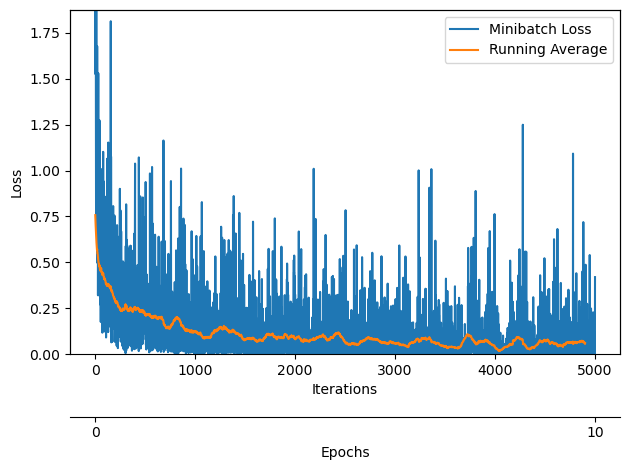

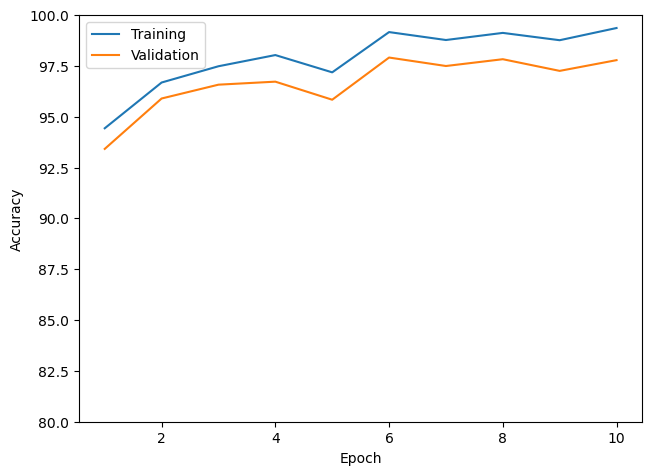

In [24]:

minibatch_loss_list, train_acc_list, valid_acc_list = train_model(
    model=model,
    num_epochs=NUM_EPOCHS,
    train_loader=train_loader,
    valid_loader=valid_loader,
    test_loader=test_loader,
    optimizer=optimizer,
    device=DEVICE,
    logging_interval=10)

# display training loss function 
plot_training_loss(minibatch_loss_list=minibatch_loss_list,
                   num_epochs=NUM_EPOCHS,
                   iter_per_epoch=len(train_loader),
                   results_dir=None,
                   averaging_iterations=100)
plt.show()

plot_accuracy(train_acc_list=train_acc_list,
              valid_acc_list=valid_acc_list,
              results_dir=None)
plt.ylim([80, 100])
plt.show()

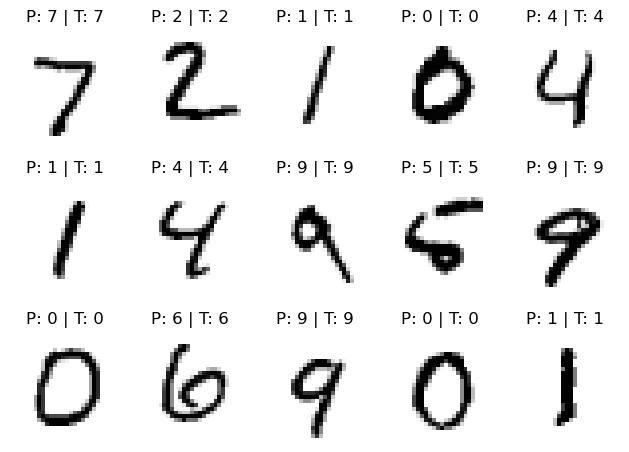

In [25]:
model.cpu()
show_examples(model=model, data_loader=test_loader)

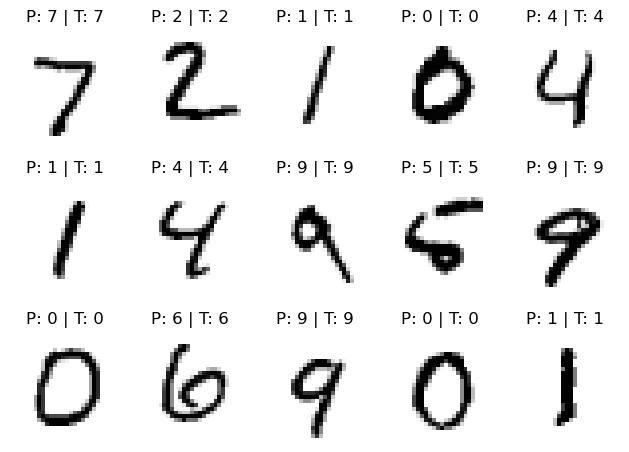

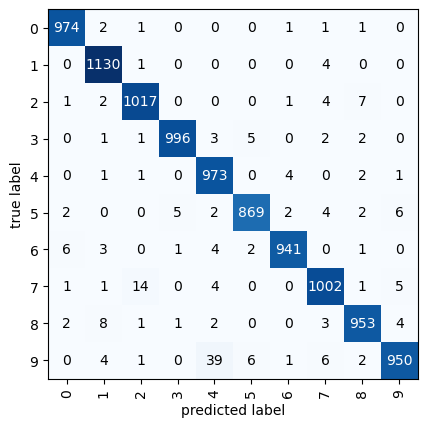

In [29]:
from ssima.arch.ResNet18.helper_evaluation import compute_confusion_matrix

show_examples(model=model, data_loader=test_loader)
class_dict = {0: '0',
              1: '1',
              2: '2',
              3: '3',
              4: '4',
              5: '5',
              6: '6',
              7: '7',
              8: '8',
              9: '9'}

mat = compute_confusion_matrix(model=model, data_loader=test_loader, device=torch.device('cpu'))
plot_confusion_matrix(mat, class_names=class_dict.values())
plt.show()

In [31]:
torch.save(obj=model.state_dict(),f="saved_data/model.pt")
torch.save(obj=optimizer.state_dict(),f="saved_data/optimizer.pt")
# torch.save(obj=scheduler.state_dict(),f="saved_data/scheduler.pt")